<div style="background-color: #c7f0db; padding: 20px; font-weight: bold;">
    <p style="text-align: center; font-size: 35px; margin:20px;">Melanoma Detection</p>
    <p style="font-size: 15px; text-align: center;"><a href="http://kwin.ir">By Saeed Khosravi</a></p>
    <img src="http://kwin.ir/projects/img1.png">
</div>

In [1]:
import numpy as np #linear algebra module
import matplotlib.pyplot as plt #plot drawing module
import os, glob # for finding and catching directories in the operating system
from sklearn.metrics import confusion_matrix # plotting the confusion matrix
from utils import * # some util functions for training, visualization and evaluating
np.random.seed(12345) # to get the same random numbers every time we run the model

# torchvision library 
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models

#torch library
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

<div style="background-color: #c7f0db; padding: 10px; ">
    <p style="text-align: left; font-size: 17px; margin:10px; font-weight: bold;">1. Loading the dataset</p>
    <a style="text-align: left; font-size: 15px; margin:10px; font-weight: bold;">https://www.kaggle.com/drscarlat/melanoma</a>
    <li style="text-align: left; margin:10px 10px 10px 20px; ">I use a smaller dataset (Tiny) to find the best possible value for hyper-parameter alpha or learning rate</li>
    <li style="text-align: left; margin:10px 10px 10px 20px; ">Also torch made it easy for us to change some of images feature such as size or contrast using transforms module that in order to take the best answer we need to determine some of them.</li>
</div>

In [2]:
# root directory of the dataset (M = Melanoma, N = Not Melanoma)
TINY_DIR = 'MD_dataset/tiny/' 
# train samples = 1000(M:500,N:500)
# valid samples = 300(M:150, N:150) 
# test samples = 300(M:150, N:150)
print('Tiny dataset folders :', os.listdir(TINY_DIR))

Tiny dataset folders : ['valid', '.DS_Store', 'test', 'train']


In [49]:
# root directory of the dataset (M = Melanoma, N = Not Melanoma)
MINI_DIR = 'MD_dataset/mini/' 
# train samples = 2000(M:500,N:500)
print('Mini dataset folders :', os.listdir(MINI_DIR))

Mini dataset folders : ['valid', '.DS_Store', 'test', 'train']


In [50]:
valid_dir = f'{TINY_DIR}valid'
test_dir = f'{TINY_DIR}test'
train_dir = f'{TINY_DIR}train'
print('dataset classes :', os.listdir(train_dir))
# in each dataset there are 2 folders that images of each class are located there

dataset classes : ['.DS_Store', 'Melanoma', 'NotMelanoma']


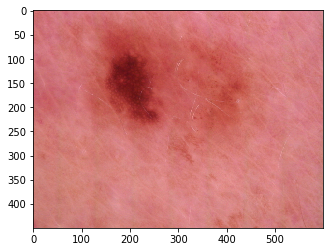

In [5]:
# picking a random image from the dataset to make sure everything goes well
#add line below to make sure that jupyter notebook shows the image
%matplotlib inline 
im_fns = glob.glob(f'{train_dir}/*/*.jpg')
plt.imshow(plt.imread(im_fns[1]))

<div style="background-color: #c7f0db; padding: 10px; ">
    <p style="text-align: left; margin:10px 10px 10px 0px; font-size: 15px; font-weight: bold;">Datasets and Dataloaders</p>
    <p style="text-align: left; margin:10px 10px 10px 20px; ">Torch datasets class takes the dataset directory and transforms or change images as we want and returns a list of tuples with 2 values</p>
    <p style="text-align: left; margin:10px 10px 10px 40px; ">1. PIL image which contains the transformed image with additional features such as image mode and size</p>
    <p style="text-align: left; margin:10px 10px 10px 40px; ">2. Class number which based on the folder in the directory. number 0 or class 0 is for folder Melanoma and number 1 or class 1 is for folder NotMelanoma</p>
</div>

In [6]:
image_size = 224
# Data augmentation and normalization for training
train_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)), # changes the size of all images to image_size * image_size
    transforms.ColorJitter(brightness=0.0, saturation=0.05, hue=0.0, contrast=0.0), # changes the image brightness, contrast, hue and saturation
    transforms.ToTensor(), # converts the images to tensor or kind of matrices
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])# mean and standard deviation of RGB channels in ImageNet dataset
])

# Just normalization for validation
valid_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),# changes the size of all images to image_size * image_size
    transforms.ToTensor(), # converts the images to tensor or kind of matrices
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])# mean and standard deviation of RGB channels in ImageNet dataset
])

# Just normalization for test
test_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),# changes the size of all images to image_size * image_size
    transforms.ToTensor(), # converts the images to tensor or kind of matrices
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])# mean and standard deviation of RGB channels in ImageNet dataset
])

In [7]:
train_ds = datasets.ImageFolder(train_dir, train_transforms)
valid_ds = datasets.ImageFolder(valid_dir, valid_transforms)
test_ds = datasets.ImageFolder(test_dir, test_transforms)

<div style="background-color: #ffb997; padding: 10px; ">
    <p style="text-align: left; margin:10px 10px 10px 20px; ">Images are still in the Disk and not loaded in the RAM yet because of a major problem. Loading Giant datasets with thousands of image samples reduces system functionality and overloads the RAM. For example 100000 images with average of 50KB image size needs 5GB of RAM. My Macbook air has 4GB of RAM</p>
    <p style="text-align: left; margin:10px 10px 10px 20px; ">In order to solve the problem we load a group of images each time that called Batch and torch takes this parameter to do so.</p>
    
</div>

In [8]:
batch_size = 8 # catch 8 images everytime a process refer to the Disk
num_of_processes = 8 # 8 subprocesses work concurrenctly to load images

train_dl = torch.utils.data.DataLoader(train_ds, 
                                       batch_size=batch_size, 
                                       shuffle=True,
                                       num_workers=8)
valid_dl = torch.utils.data.DataLoader(valid_ds, 
                                       batch_size=batch_size, 
                                       shuffle=True, 
                                       num_workers=8)
test_dl = torch.utils.data.DataLoader( test_ds, 
                                       batch_size=batch_size, 
                                       shuffle=True, 
                                       num_workers=8)

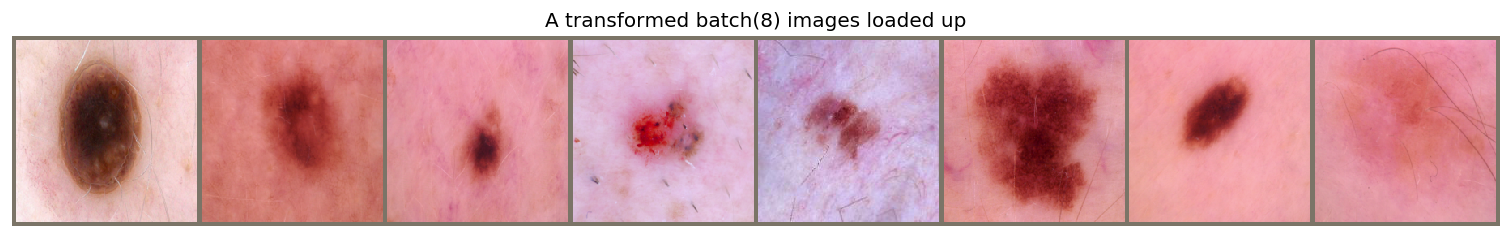

In [9]:
inputs, targets = next(iter(train_dl))
images = torchvision.utils.make_grid(inputs, padding=5)
plt.figure(figsize=(16, 12),dpi=120)
imshow(images, title=f'A transformed batch({batch_size}) images loaded up')

<div style="background-color: #c7f0db; padding: 10px; ">
    <p style="text-align: left; font-size: 17px; margin:10px; font-weight: bold;">2. Setting up a fast model</p>
    <li style="text-align: left; margin:10px 10px 10px 20px; ">I use a simple convolutional neural network to test different values torch transforms parameters</li>
    <li style="text-align: left; margin:10px 10px 10px 40px; ">My model contains of 2 convolutional layers using the ReLU action function </li>
    <li style="text-align: left; margin:10px 10px 10px 40px; ">It is better to use the BarchNorm2d function in each layer to normalize the output of the non-linear action function values</li>
    <li style="text-align: left; margin:10px 10px 10px 40px; ">It is better to use the BarchNorm2d function in each layer to normalize the output of the non-linear action function values</li>
</div>

In [10]:
model = my_cnn()

<div style="background-color: #c7f0db; padding: 10px; ">
    <p style="text-align: left; margin:10px 10px 10px 0px; font-size: 15px; font-weight: bold;">Loss function(criterion) and Optimization method</p>
    <p style="text-align: justify; margin:10px 10px 10px 20px; ">In binary class and multi-class classification networks we use a loss function called cross entropy or minus log loss to minimize the error of the weights of our model by calculating the backwards using the partial derivatives of loss function. this minimization is called optimization and the method is stochastic gradient descent. </p>
</div>

In [11]:
learning_rate = 0.0005 # step sizes to minimize the loss
momentum = 0.9 # uses to accelerate the stochastic gradient descent optimization
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

<div style="background-color: #c7f0db; padding: 10px; ">
    <p style="text-align: left; font-size: 17px; margin:10px; font-weight: bold;">3. Training the model</p>
    
</div>

In [12]:
num_epochs = 10 # number of epochs we want to update the weights using forward and backward 
losses = [] # list of all losses
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_dl):
        inputs = Variable(inputs)
        targets = Variable(targets)
        optimizer.zero_grad() # zeroing gradients to not accumulated with different batches
        outputs = model(inputs) # forward pass
        loss = criterion(outputs, targets) # calculating the loss of the forward in the last layer
        losses += [loss.item()]# add the loss to a list
        loss.backward()# backward pass -> 
        # calculating losses using partial derivatives from the last layer to the first layer
        optimizer.step() # update the weights parameters like this (wi += lr * loss)
        
        # print the loss
        if i+1 == len(train_ds) // batch_size:
            print('Epoch [%2d/%2d], Loss: %.4f'
                  % (epoch + 1, num_epochs, loss.item()))

Epoch [ 1/10], Loss: 0.2800
Epoch [ 2/10], Loss: 0.7912
Epoch [ 3/10], Loss: 0.1587
Epoch [ 4/10], Loss: 0.4115
Epoch [ 5/10], Loss: 0.3754
Epoch [ 6/10], Loss: 0.3662
Epoch [ 7/10], Loss: 0.0548
Epoch [ 8/10], Loss: 0.5596
Epoch [ 9/10], Loss: 0.1707
Epoch [10/10], Loss: 0.3361


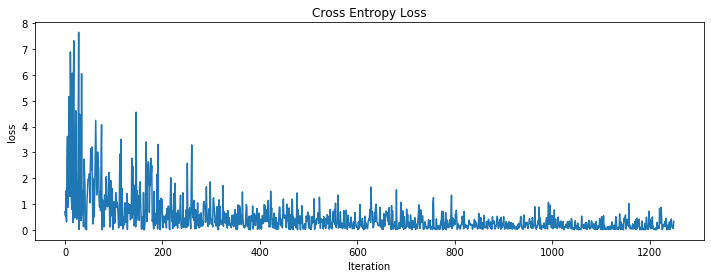

In [15]:
lsshow(losses,'Cross Entropy Loss')

<div style="background-color: #c7f0db; padding: 10px; ">
    <p style="text-align: left; font-size: 17px; margin:10px; font-weight: bold;">4. Evaluating the results</p>
    
</div>

In [16]:
ev = evaluate_model(model, valid_dl) # calculating accuracy of validation images
etr = evaluate_model(model, train_dl) # calculating accuracy of training images
ete = evaluate_model(model, test_dl) # calculating accuracy of testing images
print(f'validation {ev}\ntrain {etr}\ntest {ete}')

validation accuracy: 82.00
train accuracy: 94.00
test accuracy: 83.00


<div style="background-color: #c7f0db; padding: 20px; ">
<p style="text-align: center; font-size: 15px; font-weight: bold; ">hyper-parameters testing(5 epochs on mini)
</p>
<p style="text-align: justified; font-size: 15px; ">I have tested different values for hyper-parameters in which below values have the best result on mini dataset. </p>
<table style="width:100%">
  <tr>
    <th  style="font-weight:bold; text-align:center; border: 1px solid #8bbabb;">learning rate</th>
    <th style="font-weight:bold; text-align:center; border: 1px solid #8bbabb;">brightness</th> 
    <th style="font-weight:bold; text-align:center; border: 1px solid #8bbabb;">contrast</th>
    <th style="font-weight:bold; text-align:center; border: 1px solid #8bbabb;">saturation</th>
    <th style="font-weight:bold; text-align:center; border: 1px solid #8bbabb;">hue</th>
    <th style="font-weight:bold; text-align:center; border: 1px solid #8bbabb;">rotation</th>
    <th style="font-weight:bold; text-align:center; border: 1px solid #8bbabb;">validation</th>
    <th style="font-weight:bold; text-align:center; border: 1px solid #8bbabb;">test</th>
    <th style="font-weight:bold; text-align:center; border: 1px solid #8bbabb;">train</th>
  </tr>
  <tr>
    <td style="border: 1px solid #8bbabb; color: #1b7fbd; font-weight: bold;">0.0005</td> <!--learning rate!-->
    <td style="border: 1px solid #8bbabb; color: #1b7fbd; font-weight: bold;">0.0</td> <!--brightness!-->
    <td style="border: 1px solid #8bbabb; color: #1b7fbd; font-weight: bold;">0.0</td> <!--contrast!-->
    <td style="border: 1px solid #8bbabb; color: #1b7fbd; font-weight: bold;">0.05</td> <!--saturation!-->
    <td style="border: 1px solid #8bbabb; color: #1b7fbd; font-weight: bold;">0.0</td> <!--hue!-->
    <td style="border: 1px solid #8bbabb; color: #1b7fbd; font-weight: bold;">0.0</td> <!--rotation!-->
    <td style="border: 1px solid #8bbabb; color: #1b7fbd; font-weight: bold;">86.00</td> <!--validation!-->
    <td style="border: 1px solid #8bbabb; color: #1b7fbd; font-weight: bold;">86.00</td> <!--test!-->
    <td style="border: 1px solid #8bbabb; color: #1b7fbd; font-weight: bold;">90.00</td> <!--train!-->
  </tr>
 
</table>
</div>

100%|██████████| 38/38 [00:07<00:00,  5.00it/s]


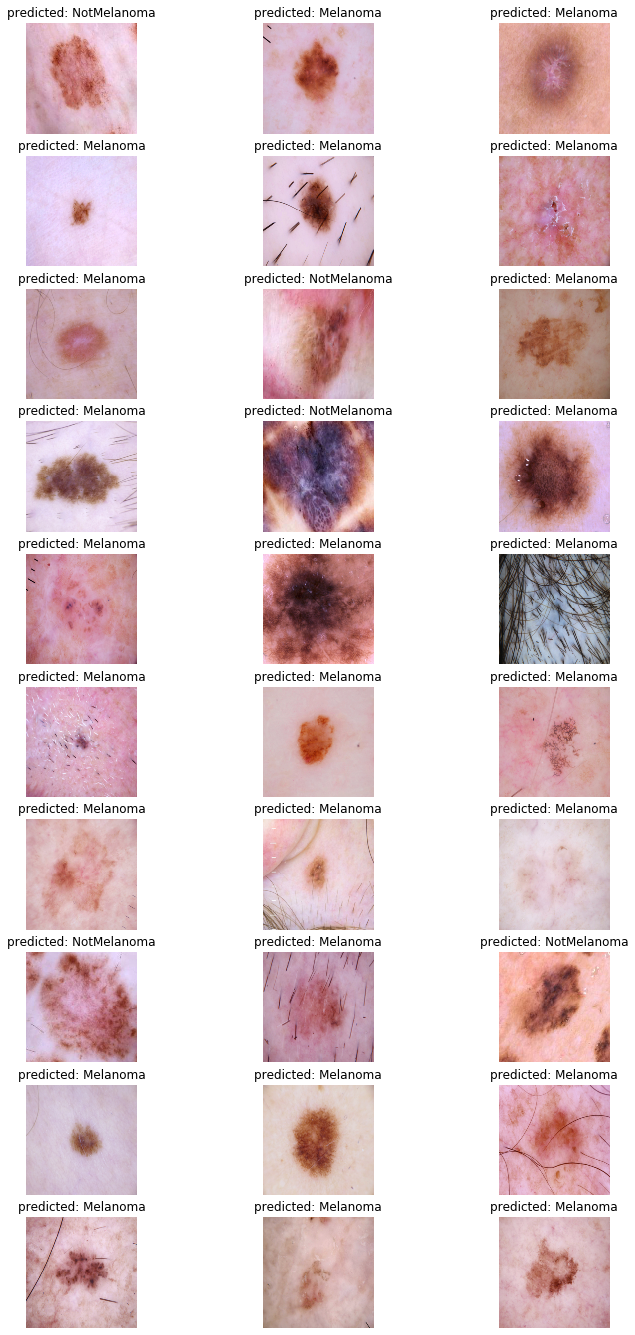

42 images out of 300 were misclassified.


In [17]:
plot_errors(model, valid_dl)

100%|██████████| 38/38 [00:07<00:00,  5.19it/s]


[[0.89333333 0.10666667]
 [0.22666667 0.77333333]]


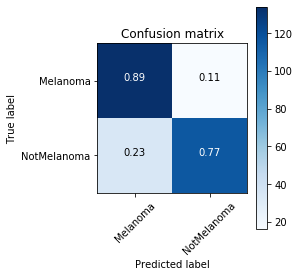

In [18]:
y_pred, y_true = predict_class(model, test_dl)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, train_ds.classes, normalize=True, figsize=(4, 4))

<div style="background-color: #c7f0db; padding: 10px; ">
    <p style="text-align: left; font-size: 17px; margin:10px; font-weight: bold;">5. Using a pre-trained network</p>
    
    
</div>

In [19]:
image_size = 224
# Data augmentation and normalization for training
train_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)), # changes the size of all images to image_size * image_size
    transforms.ColorJitter(brightness=0.0, saturation=0.05, hue=0.0, contrast=0.0), # changes the image brightness, contrast, hue and saturation
    transforms.ToTensor(), # converts the images to tensor or kind of matrices
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])# mean and standard deviation of RGB channels
])

# Just normalization for validation
valid_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),# changes the size of all images to image_size * image_size
    transforms.ToTensor(), # converts the images to tensor or kind of matrices
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])# mean and standard deviation of RGB channels
])

# Just normalization for test
test_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),# changes the size of all images to image_size * image_size
    transforms.ToTensor(), # converts the images to tensor or kind of matrices
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])# mean and standard deviation of RGB channels
])

In [20]:
train_ds = datasets.ImageFolder(train_dir, train_transforms)
valid_ds = datasets.ImageFolder(valid_dir, valid_transforms)
test_ds = datasets.ImageFolder(test_dir, test_transforms)

In [21]:
batch_size = 8 # catch 8 images everytime a process refer to the Disk
num_of_processes = 8 # 8 subprocesses work concurrenctly to load images

train_dl = torch.utils.data.DataLoader(train_ds, 
                                       batch_size=batch_size, 
                                       shuffle=True,
                                       num_workers=8)
valid_dl = torch.utils.data.DataLoader(valid_ds, 
                                       batch_size=batch_size, 
                                       shuffle=True, 
                                       num_workers=8)
test_dl = torch.utils.data.DataLoader( test_ds, 
                                       batch_size=batch_size, 
                                       shuffle=True, 
                                       num_workers=8)

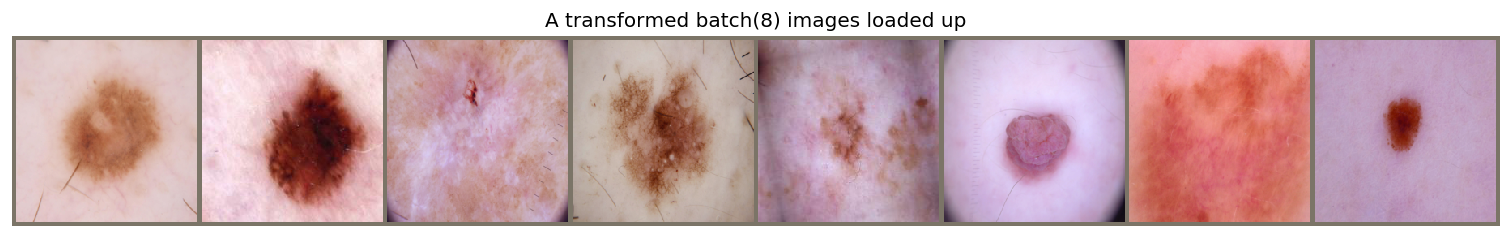

In [22]:
inputs, targets = next(iter(train_dl))
images = torchvision.utils.make_grid(inputs, padding=5)
plt.figure(figsize=(16, 12),dpi=120)
imshow(images, title=f'A transformed batch({batch_size}) images loaded up')

In [23]:
# load pre-trained ResNet50
model = models.resnet50(pretrained=True)
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

In [24]:
model = train_model(model, train_dl, valid_dl, criterion, optimizer, scheduler, num_epochs=2)

Epoch 1/2
----------
  train Loss: 0.70989 Acc: 0.00000
  valid Loss: 0.88607 Acc: 0.00000

Epoch 2/2
----------
  train Loss: 0.08118 Acc: 0.00000
  valid Loss: 0.01779 Acc: 0.00000

Training complete in 24m 21s
Best val Acc: 0.0000


In [25]:
ev = evaluate_model(model, valid_dl) # calculating accuracy of validation images
etr = evaluate_model(model, train_dl) # calculating accuracy of training images
ete = evaluate_model(model, test_dl) # calculating accuracy of testing images
print(f'validation {ev}\ntrain {etr}\ntest {ete}')

validation accuracy: 99.00
train accuracy: 100.00
test accuracy: 99.00


100%|██████████| 38/38 [00:56<00:00,  1.18s/it]


[[0.99333333 0.00666667]
 [0.00666667 0.99333333]]


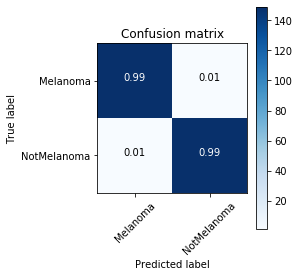

In [26]:
y_pred, y_true = predict_class(model, test_dl)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, train_ds.classes, normalize=True, figsize=(4, 4))

<div style="background-color: #c7f0db; padding: 10px; ">
    <p style="text-align: left; font-size: 17px; margin:10px; font-weight: bold;">5. Using the DermMel dataset</p>
    <p style="margin-left: 25px;">Dataset Link :<a> https://www.kaggle.com/drscarlat/melanoma</a></p>
</div>

In [27]:
# root directory of the dataset (M = Melanoma, N = Not Melanoma)
DERM_DIR = 'MD_dataset/DermMel/' 
# train samples = 1000(M:500,N:500)
# valid samples = 300(M:150, N:150) 
# test samples = 300(M:150, N:150)
print('DermMel dataset folders :', os.listdir(DERM_DIR))

DermMel dataset folders : ['valid', '.DS_Store', 'test', 'train']


In [28]:
valid_dir = f'{DERM_DIR}valid'
test_dir = f'{DERM_DIR}test'
train_dir = f'{DERM_DIR}train'
print('dataset classes :', os.listdir(train_dir))
# in each dataset there are 2 folders that images of each class are located there

dataset classes : ['.DS_Store', 'Melanoma', 'NotMelanoma']


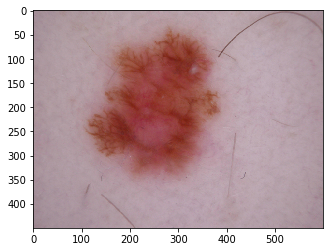

In [29]:
# picking a random image from the dataset to get sure everything goes well
#add line below to make sure that jupyter notebook shows the image
%matplotlib inline 
im_fns = glob.glob(f'{train_dir}/*/*.jpg')
plt.imshow(plt.imread(im_fns[1]))

In [30]:
image_size = 224
# Data augmentation and normalization for training
train_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)), # changes the size of all images to image_size * image_size
    transforms.ColorJitter(brightness=0.0, saturation=0.05, hue=0.0, contrast=0.0), # changes the image brightness, contrast, hue and saturation
    transforms.ToTensor(), # converts the images to tensor or kind of matrices
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])# mean and standard deviation of RGB channels
])

# Just normalization for validation
valid_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),# changes the size of all images to image_size * image_size
    transforms.ToTensor(), # converts the images to tensor or kind of matrices
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])# mean and standard deviation of RGB channels
])

# Just normalization for test
test_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),# changes the size of all images to image_size * image_size
    transforms.ToTensor(), # converts the images to tensor or kind of matrices
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])# mean and standard deviation of RGB channels
])

In [31]:
train_ds = datasets.ImageFolder(train_dir, train_transforms)
valid_ds = datasets.ImageFolder(valid_dir, valid_transforms)
test_ds = datasets.ImageFolder(test_dir, test_transforms)

In [32]:
batch_size = 8 # catch 8 images everytime a process refer to the Disk
num_of_processes = 8 # 8 subprocesses work concurrenctly to load images

train_dl = torch.utils.data.DataLoader(train_ds, 
                                       batch_size=batch_size, 
                                       shuffle=True,
                                       num_workers=8)
valid_dl = torch.utils.data.DataLoader(valid_ds, 
                                       batch_size=batch_size, 
                                       shuffle=True, 
                                       num_workers=8)
test_dl = torch.utils.data.DataLoader( test_ds, 
                                       batch_size=batch_size, 
                                       shuffle=True, 
                                       num_workers=8)

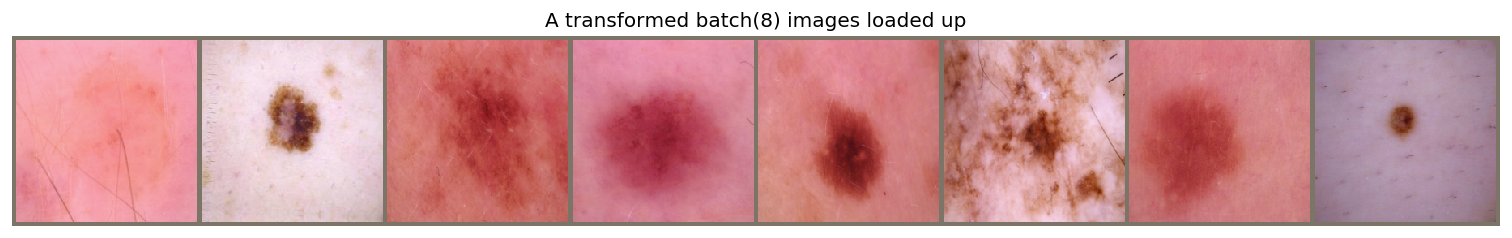

In [33]:
inputs, targets = next(iter(train_dl))
images = torchvision.utils.make_grid(inputs, padding=5)
plt.figure(figsize=(16, 12),dpi=120)
imshow(images, title=f'A transformed batch({batch_size}) images loaded up')

In [35]:
# load pre-trained ResNet50
model = models.resnet50(pretrained=True)
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

In [36]:
model = train_model(model, train_dl, valid_dl, criterion, optimizer, scheduler, num_epochs=2)

Epoch 1/2
----------
  train Loss: 0.29547 Acc: 0.00000
  valid Loss: 0.12279 Acc: 0.00000

Epoch 2/2
----------
  train Loss: 0.15820 Acc: 0.00000
  valid Loss: 0.13202 Acc: 0.00000

Training complete in 266m 38s
Best val Acc: 0.0000


In [43]:
torch.save(model, 'trained_models/model.pt')

In [42]:
ev = evaluate_model(model, valid_dl) # calculating accuracy of validation images
etr = evaluate_model(model, train_dl) # calculating accuracy of training images
ete = evaluate_model(model, test_dl) # calculating accuracy of testing images
print(f'validation {ev}\ntrain {etr}\ntest {ete}')

validation accuracy: 94.00
train accuracy: 96.00
test accuracy: 95.00


100%|██████████| 446/446 [13:14<00:00,  1.19s/it]


[[0.90735542 0.09264458]
 [0.00730337 0.99269663]]


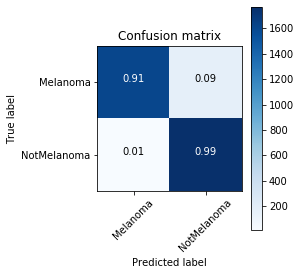

In [44]:
y_pred, y_true = predict_class(model, test_dl)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, train_ds.classes, normalize=True, figsize=(4, 4))

100%|██████████| 446/446 [13:16<00:00,  2.36s/it]


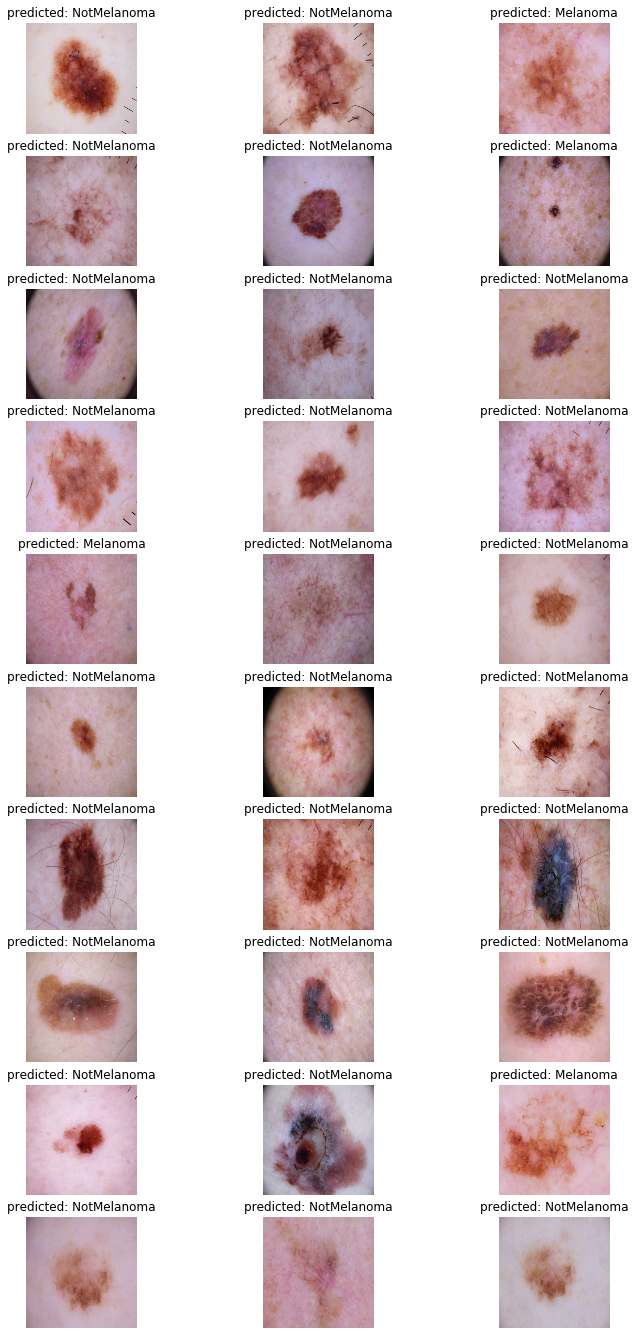

159 images out of 3562 were misclassified.


In [45]:
plot_errors(model, valid_dl)